In [10]:
## importng libraries
import re
from collections import Counter
import pyedflib
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import requests
import urllib
import pathlib
import os
from scipy import signal
import pywt
import h5py
import matplotlib.pyplot as plt
from peakDet import detect_peaks
from IPython import display
import matplotlib.gridspec as gridspec
import matplotlib.image as image
from matplotlib import animation
import seaborn as sns
import pickle
sns.set()
%matplotlib inline  

import warnings
warnings.filterwarnings('once')

from pywt import wavedec
from pywt import waverec

from scipy.signal import butter, lfilter
from scipy.signal import freqz
from scipy.signal import welch
from scipy.signal import savgol_filter
from scipy.fftpack import fft
from scipy.special import gammainc
from scipy.signal import find_peaks
from scipy import stats
import math

from pywt import wavedec
from pywt import waverec
from pywt import dwt
from sklearn.preprocessing import scale

import mne
import array

In [73]:
dir_path = '/home/tjames/work_stuff/seizure_detection/EEG_data/annotations/'
csv_filename = 'annotations_2017_A.csv'
expertA = pd.read_csv(dir_path+csv_filename)
csv_filename = 'annotations_2017_B.csv'
expertB = pd.read_csv(dir_path+csv_filename)
csv_filename = 'annotations_2017_C.csv'
expertC = pd.read_csv(dir_path+csv_filename)

```Matlab
fid = fopen(filename, 'r');
hdr = cell(1);
hdr{1} = fread(fid, 256, 'char');         % CONTAINS PATIENT INFORMATION, RECORDING INFORMATION
%stdt = char(hdr{1}(169:176)); 
%stt = char(hdr{1}(177:184));
%start_time = month_test(str2num(stdt(4:5)'))*24*60*60 + str2num(stdt(1:2)')*24*60*60 + str2num(stt(1:2)')*60*60 + str2num(stt(4:5)')*60+str2num(stt(7:8)');
len_s = str2num(char(hdr{1}(235:244))');        % START DATE AND TIME and a RESERVED
%len_s = str2num(len_s)*
rec_dur = str2num(char(hdr{1}(244:252))');
ns = char(hdr{1}(253:256))';
ns = str2num(ns);
hdr{2} = fread(fid, ns*16, 'char');    % LABEL channel label, temp or HR
hdr{3} = fread(fid, ns*80,'char');     % TRANSDUCER TYPE
hdr{4} = fread(fid, ns*8,'char');       % PHYSICAL DIMENSION, voltage - temperature
hdr{5} = fread(fid, ns*8,'char');       % PHYSICAL MIN
hdr{6} = fread(fid, ns*8,'char');       % PHYSICAL MAX
hdr{7} = fread(fid, ns*8,'char');       % DIGITAL MIN
hdr{8} = fread(fid, ns*8,'char');       % DIGITAL MAX
label = cell(1);
for jj=1:ns;
rf2 = jj*8; rf1 = rf2-7; 
label{jj} = char(hdr{2}(16*(jj-1)+1:16*(jj-1)+16));
phy_lo(jj) = str2num(char(hdr{5}(rf1:rf2))');
phy_hi(jj) = str2num(char(hdr{6}(rf1:rf2))');  
dig_lo(jj) = str2num(char(hdr{7}(rf1:rf2))');
dig_hi(jj) = str2num(char(hdr{8}(rf1:rf2))');
end
%offs = (phy_hi./dig_hi+phy_hi./dig_lo)./2; % Offset if required
scle = (phy_hi-phy_lo)./(dig_hi-dig_lo);
offs = (phy_hi+phy_lo)/2;

hdr{9} = fread(fid, ns*80,'char');                    % PRE FILTERING
hdr{10} = fread(fid, ns*8, 'char');                 % SAMPLING NO rec
nsamp = str2num(char(hdr{10})');
hdr{11} = fread(fid, ns*32,'char');     % RESERVED    
fs = nsamp/rec_dur;

% Build the empty data matrix of size INT16 not double
dat = cell(1, ns);
for jj = 1:length(nsamp);
 %   len_s.*nsamp(jj)
       dat{jj} = int16(zeros(1,len_s*nsamp(jj)));        
end

% Load data into dat array from EDF file: there are length(nsamp) channels
% and the size of each channel will be len_s * nsamp(ii)
for ii = 1:len_s;
    for jj = 1:length(nsamp);
        r1 = nsamp(jj)*(ii-1)+1; r2 = ii*nsamp(jj);
        dat{jj}(r1:r2) = fread(fid, nsamp(jj), 'short')';    
    end
end
```

In [5]:
main_dir = '/home/pag/.ml_stuff/seizure_prediction/'
sensor_location = (main_dir+'besa_81_1.txt')
f = open(sensor_location)
sensors = pd.read_csv(sensor_location, sep=',', header=None)
sensors.columns = ['chan_name','xx','yy','zz']
f.close()

def label_point(x,y,val,ax):
    a = pd.concat({'x':x, 'y':y, 'val':val}, axis=1)
    for i,point in a.iterrows():
        ax.text(point['x'],point['y'],str(point['val']))
        
eeg_channels = ['EEG Fp1-Ref','EEG Fp2-Ref','EEG F7-Ref','EEG F3-Ref','EEG Fz-Ref',
                'EEG F4-Ref','EEG F8-Ref','EEG T3-Ref','EEG C3-Ref','EEG Cz-Ref',
                'EEG C4-Ref','EEG T4-Ref','EEG T5-Ref','EEG P3-Ref','EEG Pz-Ref',
                'EEG P4-Ref','EEG T6-Ref','EEG O1-Ref','EEG O2-Ref','ECG EKG',
                'STI 014']

eeg_pairs = ['Fp1-F7','Fp2-F4','F4-C4',
             'C4-P4', 'P4-O2', 'Fp1-F3',
             'F3-C3', 'C3-P3', 'P3-O1',
             'Fp2-F8', 'F8-T4', 'T4-T6',
             'T6-O2', 'F7-T3', 'T3-T5',
             'T5-O1', 'Fz-Cz', 'Cz-Pz']
sig_win = 512
sampl_fr = 256
n_chan = 21
n_pairs = 18

def create_eeg_pairs(data,chn_pairs,raw_chns,sig_win=512,n_chan=21):
    if data.ndim == 1:
        data = data.reshape(sig_win,n_chan)
    new_data = np.zeros((data.shape[0],len(chn_pairs)))
    for idx in range(len(chn_pairs)):
        chns = chn_pairs[idx].split('-')
        chn1_idx = [i for i, j in enumerate(raw_chns) if chns[0] in j][0]
        chn2_idx = [i for i, j in enumerate(raw_chns) if chns[1] in j][0]
        new_data[:,idx] = data[:,chn1_idx] - data[:,chn2_idx]
    return new_data

def draw_eeg_pairs(chn_pairs,sens_df,clrs=None):
    fig,ax1 = plt.subplots(1,1,figsize=(8,7.5),facecolor='w',dpi=80)
    ax1.axis([-1.5,1.5,-1.5,1.5])
    chns_used = []
    
    if clrs == None:
        clrs = ['blue']*len(chn_pairs)
    for idx in range(len(chn_pairs)):
        chns = chn_pairs[idx].split('-')
        df1 = sens_df[sens_df['chan_name'].str.match(chns[0])]
        df2 = sens_df[sens_df['chan_name'].str.match(chns[1])]
        ax1.plot([df1['yy'].values[0],df2['yy'].values[0]],[df1['xx'].values[0],
                                                            df2['xx'].values[0]],clrs[idx%int(len(chn_pairs)/2)],
                linewidth=3)
        chns_used.append(chns[0])
        chns_used.append(chns[1])
        
    useful_chans = sens_df.loc[sens_df['chan_name'].isin(list(set(chns_used)))]
    ax1.scatter(useful_chans['yy'],useful_chans['xx'],s=100)
    label_point(useful_chans.yy,
                useful_chans.xx,useful_chans.chan_name,ax1)
    earX_left=[-0.985,-0.995,-1.0,-1.1,-1.1,-1.0,-0.995,-0.985]
    earY_left=[0.25,0.25,0.24,0.18,-0.18,-0.24,-0.25,-0.25]
    earX_right=[0.965,0.985,1.0,1.1,1.1,1.0,0.985,0.965]
    earY_right=[0.25,0.25,0.24,0.18,-0.18,-0.24,-0.25,-0.25]
    noseX = [-0.10,-0.05,0.00,0.05,0.10]
    noseY = [1.0,1.1,1.2,1.1,1.0]
    ax1.plot(earX_left,earY_left,earX_right,earY_right,noseX,noseY,color='k',linewidth = 3)
    circ = plt.Circle((0,0), radius=1, fc='y',color='k', fill=False, linewidth = 3)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('TOP OF HEAD')
    plt.text(-1.2,-0.3,'Left',fontsize=14)
    plt.text(1.05,-0.3,'Right',fontsize=14)
    plt.text(0,1.2,'Nasion',fontsize=14)
    plt.gca().add_patch(circ)
    plt.show()

    return None


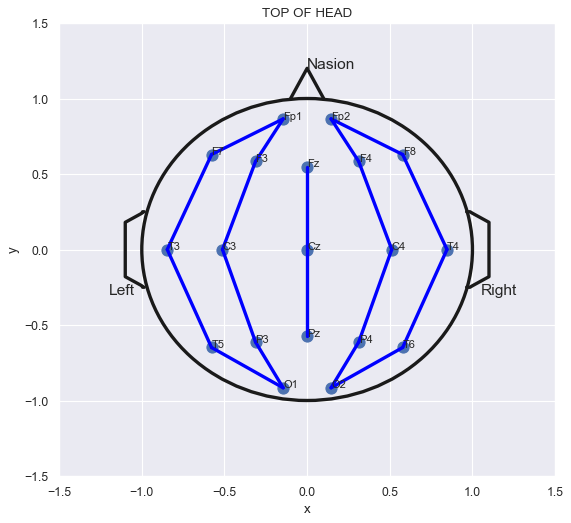

In [6]:
draw_eeg_pairs(eeg_pairs,sensors)

LETS START THE FUN

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


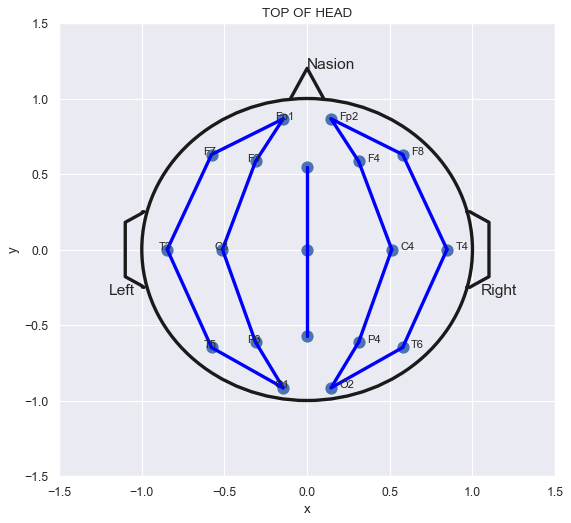

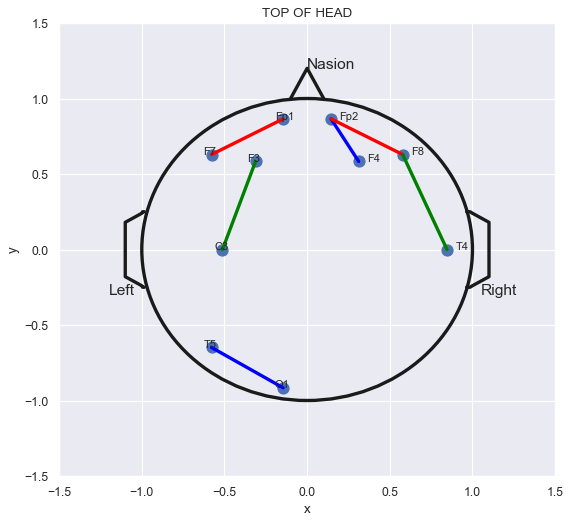

In [1246]:
sel_pairs = [eeg_pairs[idx] for idx in left_hemi+right_hemi ]
clrs_pairs = ['blue','red','green','darkblue','darkred','darkorange','darkgreen','cyan','magenta']
draw_eeg_pairs(eeg_pairs,sensors)
draw_eeg_pairs(sel_pairs,sensors,clrs_pairs)

# Data preprocessing

## Splitting into seizure and nonseizure

In [74]:
def read_edf(dir_path,file_name):
    f = pyedflib.EdfReader(dir_path+'/'+file_name)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
         sigbufs[i, :] = f.readSignal(i)
    f._close()
    del f
    return sigbufs.transpose(),n,signal_labels

def convert_annotations(csvA,csvB,csvC,pat_id,eeg_signal_size):
    plcholder_arr = np.ones((int(eeg_signal_size/256),256))
    
    expA_patient = csvA[pat_id].values
    expertA_annon = expA_patient[:int(eeg_signal_size/256),np.newaxis]*plcholder_arr
    #expertA_annon[ expertA_annon==0 ] = np.nan
    
    expB_patient = csvB[pat_id].values
    expertB_annon = expB_patient[:int(eeg_signal_size/256),np.newaxis]*plcholder_arr
    #expertB_annon[ expertB_annon==0 ] = np.nan
    
    expC_patient = csvC[pat_id].values
    expertC_annon = expC_patient[:int(eeg_signal_size/256),np.newaxis]*plcholder_arr
    #expertC_annon[ expertC_annon==0 ] = np.nan
    
    return [expertA_annon,
            expertB_annon,
            expertC_annon]

def create_h5py(dir_path,opn_idx,patient_id,signal,cat):
    h5f_signal = h5py.File(dir_path+'/FINNISH_extracted/'+cat+'_'+str(opn_idx)+'_'+'patient'+patient_id+'.h5','w')
    h5f_signal.create_dataset(cat,data=signal,compression='gzip',compression_opts=9)
    h5f_signal.close() 
    return None 

def create_windowed_segs(signal,n_chan = 18):
    sig_win = 512
    sampl_fr = 256
    if signal.shape[0]%sig_win == 0:
        signal_segs = signal.reshape(int(signal.shape[0]/sig_win),
                                                    sig_win,n_chan).transpose(1,2,0)
    else:
        signal_segs = signal[:-sampl_fr,:].reshape(int((signal.shape[0]-sampl_fr)/sig_win),
                                                           sig_win,n_chan).transpose(1,2,0)
    signal_segs = signal_segs.reshape(sig_win*n_chan,-1)
    
    return signal_segs

In [87]:
def extract_eeg_seizure_segs(expertA,expertB,expertC,opn_idx=2):
    n_chan = 21
    sig_win = 512
    sampl_fr = 256
    main_dir_path = '/home/tjames/work_stuff/seizure_detection/EEG_data'
    data_dir = 'raw_data_FINNISH'
    eeg_files = os.listdir(main_dir_path+'/'+data_dir)
    
    for edf_file_no in range(len(eeg_files)):
        edf_file_name = eeg_files[edf_file_no]
        if not edf_file_name.endswith(".edf"):
            continue
            
        try:
        
            eeg_signal,n,signal_labels = read_edf(main_dir_path+'/'+data_dir,edf_file_name)
            assert n_chan == len(signal_labels)
            no_of_secs = int(eeg_signal.shape[0]/sampl_fr)
            patient_id = edf_file_name.split('eeg')[1].split('.')[0]

            majority_opinion = np.sum([expertA.iloc[0:no_of_secs][patient_id].values,
                                       expertB.iloc[0:no_of_secs][patient_id].values,
                                       expertC.iloc[0:no_of_secs][patient_id].values],axis=0)
            idxs_ = np.where(majority_opinion>=opn_idx)[0]
            if idxs_.shape[0] <= 1:
                print('NO seizure segs which satisfyies the opinion for patient ',patient_id,' found.')
                continue
            seq_points = np.where(np.diff(idxs_)>1)[0]
            seizure_segs = np.zeros((sig_win*n_chan,1))

            if seq_points.size == 0:
                segs_ = create_windowed_segs(eeg_signal[idxs_[0]*sampl_fr:
                                                        idxs_[-1]*sampl_fr,:],n_chan)
                seizure_segs = np.column_stack((seizure_segs,segs_))
            else:
                if seq_points[0] > 0:
                    seq_points = np.append(0,seq_points)
                if seq_points[-1] < idxs_.shape[0]:
                    seq_points = np.append(seq_points,idxs_.shape[0]-1)
                seq_points_idx_arr = np.column_stack((seq_points[:-1]+1,seq_points[1:]))        
                for idx in range(seq_points_idx_arr.shape[0]):
                    st_ = seq_points_idx_arr[idx][0] ; en_ = seq_points_idx_arr[idx][1]
                    segs_ = create_windowed_segs(eeg_signal[(idxs_[st_])*sampl_fr:
                                                            (idxs_[en_])*sampl_fr,:],n_chan)

                    seizure_segs = np.column_stack((seizure_segs,segs_))

            seizure_segs = np.delete(seizure_segs,0,1)

            print('Finished extracting seizure with opinion index ',str(opn_idx),'for patient ',patient_id)
            print('There are ',str(seizure_segs.shape[1]),' seizure segments')
            #np.save(dir_path+'/extracted/'+'seizure_'+str(opn_idx)+'_'+'patient'+patient_id,seizure_segs)
            create_h5py(main_dir_path,opn_idx,patient_id,seizure_segs,'seizures')
        except:
            print('Error detected in ',edf_file_name)
        
    return None

In [104]:
extract_eeg_seizure_segs(expertA,expertB,expertC,3)

NO seizure segs which satisfyies the opinion for patient  49  found.
NO seizure segs which satisfyies the opinion for patient  55  found.
NO seizure segs which satisfyies the opinion for patient  42  found.
NO seizure segs which satisfyies the opinion for patient  10  found.
NO seizure segs which satisfyies the opinion for patient  60  found.
Finished extracting seizure with opinion index  3 for patient  76
There are  185  seizure segments
NO seizure segs which satisfyies the opinion for patient  56  found.
NO seizure segs which satisfyies the opinion for patient  57  found.
Finished extracting seizure with opinion index  3 for patient  7
There are  297  seizure segments
Finished extracting seizure with opinion index  3 for patient  67
There are  658  seizure segments
NO seizure segs which satisfyies the opinion for patient  61  found.
Finished extracting seizure with opinion index  3 for patient  1
There are  352  seizure segments
Finished extracting seizure with opinion index  3 for 

In [101]:
def extract_eeg_nonseizure_segs(expertA,expertB,expertC,opn_idx=0):
    n_chan = 21
    sig_win = 512
    sampl_fr = 256
    main_dir_path = '/home/tjames/work_stuff/seizure_detection/EEG_data'
    data_dir = 'raw_data_FINNISH'
    eeg_files = os.listdir(main_dir_path+'/'+data_dir)
    
    for edf_file_no in range(len(eeg_files)):
        edf_file_name = eeg_files[edf_file_no]
        if not edf_file_name.endswith(".edf"):
            continue
            
        try:
        
            eeg_signal,n,signal_labels = read_edf(main_dir_path+'/'+data_dir,edf_file_name)
            assert n_chan == len(signal_labels)
            no_of_secs = int(eeg_signal.shape[0]/sampl_fr)
            patient_id = edf_file_name.split('eeg')[1].split('.')[0]

            majority_opinion = np.sum([expertA.iloc[0:no_of_secs][patient_id].values,
                                       expertB.iloc[0:no_of_secs][patient_id].values,
                                       expertC.iloc[0:no_of_secs][patient_id].values],axis=0)
            idxs_ = np.where(majority_opinion==0)[0]
            if idxs_.shape[0] <= 1:
                print('NO non-seizure segs which satisfyies the opinion for patient ',patient_id,' found.')
                continue
            seq_points = np.where(np.diff(idxs_)>1)[0]
            nonseizure_segs = np.zeros((sig_win*n_chan,1))

            if seq_points.size == 0:
                segs_ = create_windowed_segs(eeg_signal[idxs_[0]*sampl_fr:
                                                        idxs_[-1]*sampl_fr,:],n_chan)
                nonseizure_segs = np.column_stack((nonseizure_segs,segs_))
            else:
                if seq_points[0] > 0:
                    seq_points = np.append(0,seq_points)
                if seq_points[-1] < idxs_.shape[0]:
                    seq_points = np.append(seq_points,idxs_.shape[0]-1)
                seq_points_idx_arr = np.column_stack((seq_points[:-1]+1,seq_points[1:]))        
                for idx in range(seq_points_idx_arr.shape[0]):
                    st_ = seq_points_idx_arr[idx][0] ; en_ = seq_points_idx_arr[idx][1]
                    segs_ = create_windowed_segs(eeg_signal[(idxs_[st_])*sampl_fr:
                                                            (idxs_[en_])*sampl_fr,:],n_chan)

                    nonseizure_segs = np.column_stack((nonseizure_segs,segs_))

            nonseizure_segs = np.delete(nonseizure_segs,0,1)

            print('Finished extracting nonseizure segs for patient ',patient_id)
            print('There are ',str(nonseizure_segs.shape[1]),' nonseizure segments')
            #np.save(dir_path+'/extracted/'+'nonseizure_'+str(0)+'_'+'patient'+patient_id,nonseizure_segs)
            create_h5py(main_dir_path,opn_idx,patient_id,nonseizure_segs,'nonseizures')

        except:
            print('Error detected in ',edf_file_name)

    return None

In [102]:
extract_eeg_nonseizure_segs(expertA,expertB,expertC)

Finished extracting nonseizure segs for patient  49
There are  4321  nonseizure segments
Finished extracting nonseizure segs for patient  55
There are  2580  nonseizure segments
Finished extracting nonseizure segs for patient  42
There are  2486  nonseizure segments
Finished extracting nonseizure segs for patient  10
There are  2713  nonseizure segments
Finished extracting nonseizure segs for patient  60
There are  1889  nonseizure segments
Finished extracting nonseizure segs for patient  76
There are  1588  nonseizure segments
Finished extracting nonseizure segs for patient  56
There are  1506  nonseizure segments
Finished extracting nonseizure segs for patient  57
There are  1566  nonseizure segments
Finished extracting nonseizure segs for patient  7
There are  1319  nonseizure segments
Finished extracting nonseizure segs for patient  67
There are  1536  nonseizure segments
Finished extracting nonseizure segs for patient  61
There are  2847  nonseizure segments
Finished extracting no

In [137]:
## create training and test set
def extract_data(cat,opn_idx,range_st,range_end,patient_ids,single_patient=False,sig_win=512):
    main_dir_path = '/home/tjames/work_stuff/seizure_detection/EEG_data/'
    data_dir = 'FINNISH_extracted/'
    

    _categoryData = np.zeros((sig_win*21,1))
    patient_id_holder = []
    no_of_elements = []
    start_id = patient_ids[0]
    end_id = patient_ids[1]
    if single_patient:
        end_id = start_id +1
    for idx in patient_ids:
        fname = main_dir_path+data_dir+cat+'_'+str(opn_idx)+'_'+'patient'+str(idx)+'.h5'
        path = pathlib.Path(fname)
        if not path.exists():
            continue
        
        h5f = h5py.File(fname,'r')
        
        try:
            arr_hold = h5f[cat][:,range_st:range_end]
            print('extracted from',cat+'_'+str(opn_idx)+'_'+'patient'+str(idx)+'.h5')
            _categoryData = np.hstack((_categoryData,arr_hold))
            patient_id_holder.append([idx]*arr_hold.shape[1])
            no_of_elements.append(arr_hold.shape[1])
        except:
            print('warning.not enough data for patient '+str(idx))
        h5f.close()

    return np.delete(_categoryData,0,1),np.hstack(patient_id_holder),no_of_elements

In [138]:
patient_idxs = list(range(1,80))
nonseizure_data,patient_ids_ns,ns_eles = extract_data('nonseizures',0,2,200,patient_idxs,
                                                     single_patient=False)
seizure_data,patient_ids_s,s_eles = extract_data('seizures',1,5,100,patient_idxs,single_patient=False)

extracted from nonseizures_0_patient1.h5
extracted from nonseizures_0_patient2.h5
extracted from nonseizures_0_patient3.h5
extracted from nonseizures_0_patient5.h5
extracted from nonseizures_0_patient6.h5
extracted from nonseizures_0_patient7.h5
extracted from nonseizures_0_patient8.h5
extracted from nonseizures_0_patient9.h5
extracted from nonseizures_0_patient10.h5
extracted from nonseizures_0_patient11.h5
extracted from nonseizures_0_patient12.h5
extracted from nonseizures_0_patient13.h5
extracted from nonseizures_0_patient14.h5
extracted from nonseizures_0_patient15.h5
extracted from nonseizures_0_patient16.h5
extracted from nonseizures_0_patient17.h5
extracted from nonseizures_0_patient18.h5
extracted from nonseizures_0_patient19.h5
extracted from nonseizures_0_patient20.h5
extracted from nonseizures_0_patient21.h5
extracted from nonseizures_0_patient22.h5
extracted from nonseizures_0_patient23.h5
extracted from nonseizures_0_patient24.h5
extracted from nonseizures_0_patient25.h5


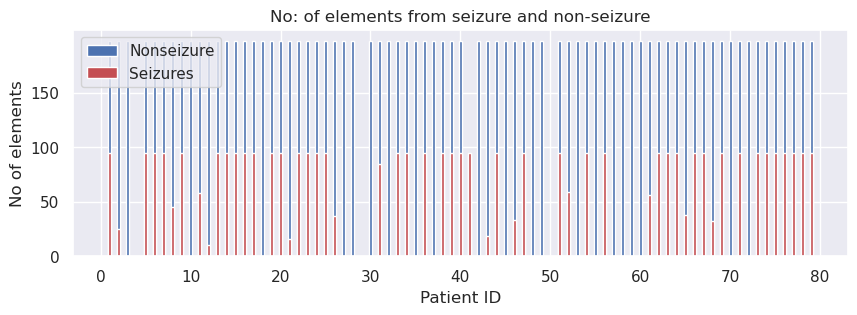

In [147]:
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(facecolor='w',figsize=(10,3),dpi=100)
ind = np.unique(patient_ids_ns)   # the x locations for the groups
p1 = plt.bar(ind, ns_eles, width,color='b')
ind = np.unique(patient_ids_s)   # the x locations for the groups
p2 = plt.bar(ind, s_eles, width,color='r')
plt.ylabel('No of elements',fontsize=12)
plt.title('No: of elements from seizure and non-seizure',fontsize=12)
plt.yticks(np.arange(0, 200, 50))
plt.legend((p1[0], p2[0]), ('Nonseizure', 'Seizures'))
plt.xlabel('Patient ID',fontsize=12)

plt.show()

In [148]:
print('The shape of seizure array is ',str(seizure_data.shape))
print('The shape of non-seizure array is',str(nonseizure_data.shape))

The shape of seizure array is  (10752, 4503)
The shape of non-seizure array is (10752, 14942)


In [166]:
sig_win=512
n_chan=21
raw_eeg_channels = ['EEG Fp1-REF','EEG Fp2-REF','EEG F3-REF','EEG F4-REF','EEG C3-REF','EEG C4-REF',
                    'EEG P3-REF','EEG P4-REF','EEG O1-REF','EEG O2-REF','EEG F7-REF','EEG F8-REF',
                    'EEG T3-REF','EEG T4-REF','EEG T5-REF','EEG T6-REF','EEG Fz-REF','EEG Cz-REF','EEG Pz-REF',
                    'ECG EKG-REF','Resp Effort-REF']

eeg_pairs = ['Fp1-F7','Fp2-F4','F4-C4',
             'C4-P4', 'P4-O2', 'Fp1-F3',
             'F3-C3', 'C3-P3', 'P3-O1',
             'Fp2-F8', 'F8-T4', 'T4-T6',
             'T6-O2', 'F7-T3', 'T3-T5',
             'T5-O1', 'Fz-Cz', 'Cz-Pz']
n_pairs = len(eeg_pairs)

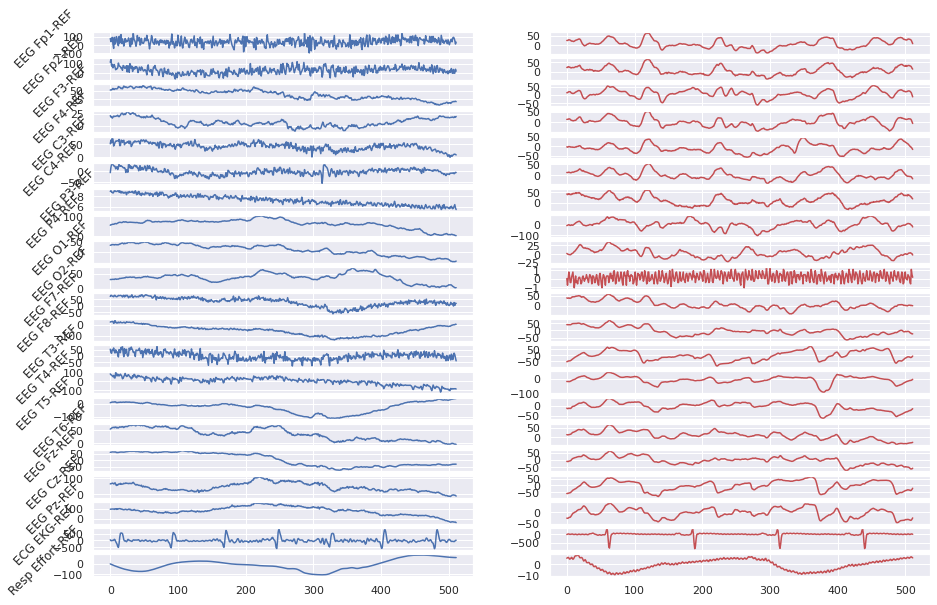

In [156]:
ind = np.unique(patient_ids_ns)   # the x locations for the groups
ind = np.unique(patient_ids_ns)   # the x locations for the groups
fig,axes = plt.subplots(21,2,figsize=(15,10), facecolor='w',sharey=False)
xx_ns = nonseizure_data[:,200].reshape(sig_win,n_chan)
xx_s = seizure_data[:,200].reshape(sig_win,n_chan)
for idx in range(n_chan):
    axes[idx,0].plot(xx_ns[:,idx],'b')
    axes[idx,1].plot(xx_s[:,idx],'r')
    axes[idx,0].set_ylabel(raw_eeg_channels[idx],rotation = 45)

plt.show()

In [163]:
def create_eeg_pairs(data,chn_pairs,raw_chns,sig_win=512,n_chan=21):
    chn_pairs = list(chn_pairs)
    raw_chns = list(raw_chns)
    if data.ndim == 1:
        data = data.reshape(sig_win,n_chan)
    new_data = np.zeros((data.shape[0],len(chn_pairs)))
    for idx in range(len(chn_pairs)):
        chns = chn_pairs[idx].split('-')
        #print(chns)
        chn1_idx = [raw_chns.index(i) for i in raw_chns if chns[0] in i][0]
        chn2_idx = [raw_chns.index(i) for i in raw_chns if chns[1] in i][0]
        #print(chn1_idx,chn2_idx)
        new_data[:,idx] = data[:,chn1_idx] - data[:,chn2_idx]
    return new_data

def pair_ify_the_data(seizure_signal,nonseizure_signal,chn_pairs,raw_chns,sig_win=512):
    
    seizure_signal = np.apply_along_axis(create_eeg_pairs,0,seizure_signal,chn_pairs,raw_chns)
    nonseizure_signal = np.apply_along_axis(create_eeg_pairs,0,nonseizure_signal,chn_pairs,raw_chns)
    seizure_signal = seizure_signal.reshape(sig_win*len(chn_pairs),-1)
    nonseizure_signal = nonseizure_signal.reshape(sig_win*len(chn_pairs),-1)

    
    return seizure_signal,nonseizure_signal 

In [164]:
seizure_data,nonseizure_data = pair_ify_the_data(seizure_data,nonseizure_data,eeg_pairs,raw_eeg_channels)

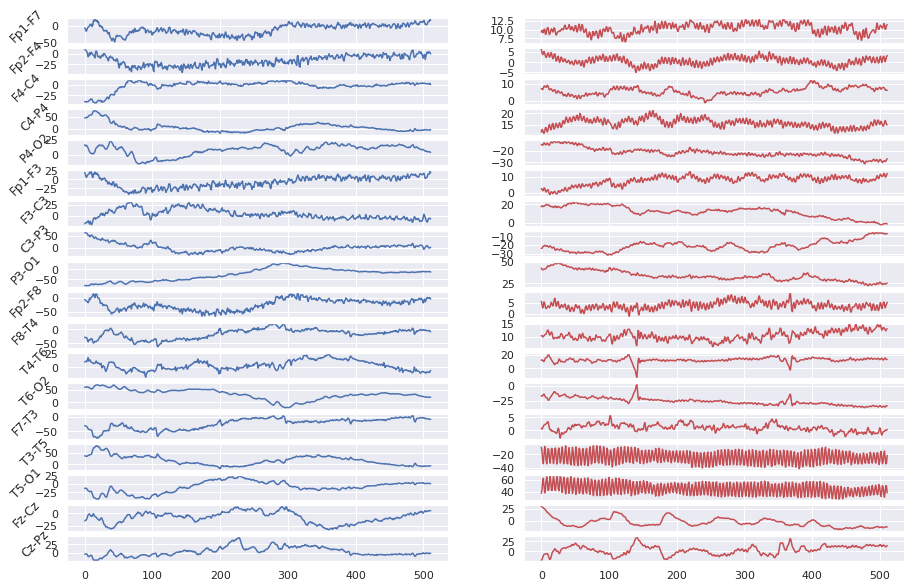

In [167]:
fig,axes = plt.subplots(n_pairs,2,figsize=(15,10), facecolor='w',sharey=False)
xx_ns = nonseizure_data[:,455].reshape(sig_win,n_pairs)
xx_s = seizure_data[:,29].reshape(sig_win,n_pairs)
for idx in range(n_pairs):
    axes[idx,0].plot(xx_ns[:,idx],'b')
    axes[idx,1].plot(xx_s[:,idx],'r')
    axes[idx,0].set_ylabel(eeg_pairs[idx],rotation = 45)

plt.show()

In [13]:
def _axis_wise_norm(row_slice,a,b):
    return (b-a)*np.divide((row_slice - np.min(row_slice)),(np.max(row_slice) - np.min(row_slice))) + a

def chunks(arr,cols_size, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, cols_size, n):
        yield arr[:,i:i + n]

def apply_func_chunks(arr,a,b,split_by = 12):
    #col_idxs =  np.arange(0,arr.shape[1],arr.shape[1]//split_by)
    arr_chunks = list(chunks(arr,arr.shape[1],split_by))
    result_arr = np.apply_along_axis(_axis_wise_norm,0,arr_chunks[0],a,b)
    for ii in range(1,len(arr_chunks)):
        norm_arr_chunk =  np.apply_along_axis(_axis_wise_norm,0,arr_chunks[ii],a,b)
        result_arr = np.hstack([result_arr,norm_arr_chunk])
    return result_arr

In [14]:
# normalize both the data set
# do not run this function seperately. this functionality is incluced in the preprocess function
def norm_shift(seizure_data,nonseizure_data,a,b,normalize_along_rows=False):
    seizure_data = (seizure_data-seizure_data.mean())/seizure_data.std()
    nonseizure_data = (nonseizure_data-nonseizure_data.mean())/nonseizure_data.std()
    if normalize_along_rows:
        seizure_data = apply_func_chunks(seizure_data,a,b,100)
        nonseizure_data = apply_func_chunks(nonseizure_data,a,b,100)        
    else:
        seizure_data = ((b-a)*np.divide((seizure_data - np.min(seizure_data)),(np.max(seizure_data) - 
                                                                      np.min(seizure_data)))) + a
        nonseizure_data = ((b-a)*np.divide((nonseizure_data - np.min(nonseizure_data)),(np.max(nonseizure_data) - 
                                                                               np.min(nonseizure_data)))) + a
    print('The max of nonseizure data is',str(np.max(nonseizure_data)),'and min is',str(np.min(nonseizure_data)))
    print('The max of seizure data is',str(np.max(seizure_data)),'and min is',str(np.min(seizure_data)))
    
    
    
    return seizure_data,nonseizure_data

In [15]:
def shuffle_columns(X):
    perm_order = np.random.permutation(X.shape[1])
    X_shuffle = X[:, perm_order]
    return X_shuffle, perm_order

def define_split_boundary(train_split,test_split,val_split,m):
    m_train = int(train_split*m)
    m_test = m_train + int(test_split*m)
    m_val = m_test + int(val_split*m)
    
    return m_train, m_test, m_val
    

def create_train_test_val(seizure_set,nonseizure_set,train_split,test_split):
    val_split = round((1.0- train_split - test_split),2)
    seizure_set,_ = shuffle_columns(seizure_set)
    nonseizure_set,_ = shuffle_columns(nonseizure_set)
    seizure_set = np.vstack((seizure_set, np.ones((1, seizure_set.shape[1]))))
    nonseizure_set = np.vstack((nonseizure_set, np.zeros((1, nonseizure_set.shape[1]))))
    m_train_s,m_test_s,m_val_s = define_split_boundary(train_split,
                                                       test_split,val_split,seizure_set.shape[1])
    m_train_ns,m_test_ns,m_val_ns = define_split_boundary(train_split,
                                                          test_split,val_split,nonseizure_set.shape[1])
    train_set = np.hstack((seizure_set[:,1:m_train_s],nonseizure_set[:,1:m_train_ns]))
    test_set = np.hstack((seizure_set[:,m_train_s:m_test_s],nonseizure_set[:,m_train_ns:m_test_ns]))
    val_set = np.hstack((seizure_set[:,m_test_s:m_val_s],nonseizure_set[:,m_test_ns:m_val_ns]))
    
    return train_set, test_set, val_set

In [16]:
def preprocess(seizure_data,nonseizure_data,b=1.0,a=-1.0,norm_rows=False,do_norm_shift=True,
               train_frac=0.90,test_frac=0.05):
    if do_norm_shift:
        seizure_data,nonseizure_data = norm_shift(seizure_data,nonseizure_data,b,a,norm_rows)
    train_data,test_data,val_data = create_train_test_val(seizure_data,nonseizure_data,train_frac,
                                                          test_frac)
    train_data,_ = shuffle_columns(train_data)
    test_data,_ = shuffle_columns(test_data)
    val_data,_ = shuffle_columns(val_data)
    train_x = train_data[:-1, :]  # take all the columns expect the last
    test_x = test_data[:-1, :]
    val_x = val_data[:-1,:]
    train_y = train_data[-1, :].reshape((1, train_data.shape[1]))
    test_y = test_data[-1, :].reshape((1, test_data.shape[1]))
    val_y = val_data[-1, :].reshape((1, val_data.shape[1]))
    
    return train_x,val_x,test_x,train_y,val_y,test_y

In [17]:
def create_train_test(seizure_set,nonseizure_set,id_order_s,id_order_ns,train_patient_list,test_patient_list):
    seizure_set,perm_order_s = shuffle_columns(seizure_set)
    nonseizure_set,perm_order_ns = shuffle_columns(nonseizure_set)
    id_order_s = id_order_s[perm_order_s]
    id_order_ns = id_order_ns[perm_order_ns]
    seizure_set = np.vstack((seizure_set, np.ones((1, seizure_set.shape[1]))))
    nonseizure_set = np.vstack((nonseizure_set, np.zeros((1, nonseizure_set.shape[1]))))
    train_set = np.hstack((seizure_set[:,np.where(np.isin(id_order_s,train_patient_list)==1)[0]],
                          nonseizure_set[:,np.where(np.isin(id_order_ns,train_patient_list)==1)[0]]))
    test_set = np.hstack((seizure_set[:,np.where(np.isin(id_order_s,test_patient_list)==1)[0]],
                          nonseizure_set[:,np.where(np.isin(id_order_ns,test_patient_list)==1)[0]]))
    
    return train_set,test_set
    

def patient_specific_preprocess(seizure_data,nonseizure_data,id_catalogue_s,id_catalogue_ns,
                                train_patient_list,test_patient_list,
                                b=1.0,a=-1.0,norm_rows=False,do_norm_shift=True):
    if do_norm_shift:
        seizure_data,nonseizure_data = norm_shift(seizure_data,nonseizure_data,b,a,norm_rows)
    train_data,test_data = create_train_test(seizure_data,nonseizure_data,id_catalogue_s,id_catalogue_ns,
                                            train_patient_list,test_patient_list)
    train_data,_ = shuffle_columns(train_data)
    test_data,_ = shuffle_columns(test_data)
    train_x = train_data[:-1, :]  # take all the columns expect the last
    test_x = test_data[:-1, :]
    train_y = train_data[-1, :].reshape((1, train_data.shape[1]))
    test_y = test_data[-1, :].reshape((1, test_data.shape[1]))
    
    return train_x,test_x,train_y,test_y

In [18]:
train_x,val_x,test_x,train_y,val_y,test_y = preprocess(seizure_data,nonseizure_data[:,0:10000],norm_rows=False) 

The max of nonseizure data is 1.0 and min is -1.0
The max of seizure data is 1.0 and min is -1.0


In [19]:
_, counts_train = np.unique(train_y, return_counts=True)
print('The percentage of seizures in train data is ',(counts_train[1]/counts_train[0])*100)
_, counts_test = np.unique(test_y, return_counts=True)
print('The percentage of seizures in test data is ',(counts_test[1]/counts_test[0])*100)

The percentage of seizures in train data is  32.11467940882321
The percentage of seizures in test data is  32.0


In [20]:
patient_with_3_deg_sez = [0,3,4,6,8,10,12,13,14,15,16,18,19,20,21,24,30,33,35,37,
                          38,39,40,43,46,49,50,51,61,62,65,66,68,72,74,75,76,77,78]
patient_with_no_3_deg_sez = [x for x in patient_idxs if x not in patient_with_3_deg_sez]

**Lot 1**

train_patients = patient_with_3_deg_sez[:25]+patient_with_no_3_deg_sez[:30]

test_patients = patient_with_3_deg_sez[25:-1]+patient_with_no_3_deg_sez[30:-1]

**Lot 2**

train_patients = patient_with_3_deg_sez[25:-1]+patient_with_no_3_deg_sez[30:-1]

test_patients = patient_with_3_deg_sez[:25]+patient_with_no_3_deg_sez[:30]

**Lot 3**

train_patients = patient_with_no_3_deg_sez[:]

test_patients = patient_with_3_deg_sez[:]


In [397]:
train_patients = patient_with_3_deg_sez[:25]+patient_with_no_3_deg_sez[:30]

test_patients = patient_with_3_deg_sez[25:-1]+patient_with_no_3_deg_sez[30:-1]

train_x,test_x,train_y,test_y = patient_specific_preprocess(seizure_data,nonseizure_data,patient_ids_s-1,
                                                           patient_ids_ns-1,train_patients,test_patients,
                                                           -1,1)

The max of nonseizure data is 1.0 and min is -1.0
The max of seizure data is 1.0 and min is -1.0


In [400]:
_, counts_train = np.unique(train_y, return_counts=True)
if counts_train.size == 1:
    counts_train = np.append(counts_train,0)
print('The percentage of seizures in train data is ',(counts_train[1]/counts_train[0])*100)

_, counts_test = np.unique(test_y, return_counts=True)
if counts_test.size == 1:
    counts_test = np.append(counts_test,0)
print('The percentage of seizures in test data is ',(counts_test[1]/counts_test[0])*100)

The percentage of seizures in train data is  27.707715133531156
The percentage of seizures in test data is  35.35353535353536


## ANN

In [185]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [186]:
def initialize_parameters_deep(layer_dims,weight_scale):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])
        #parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * weight_scale
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [187]:
def initialize_parameters_deep(layer_dims,weight_scale):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])
        #parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * weight_scale
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation,keep_prob):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
        assert (A.shape == (W.shape[0], A_prev.shape[1]))
        cache = (linear_cache, activation_cache)
        
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
        if keep_prob < 1.0:
            D = np.random.rand(A.shape[0], A.shape[1])
            D = D < keep_prob
            A = A * D
            A = A / keep_prob
            
            assert (A.shape == (W.shape[0], A_prev.shape[1]))
            cache = (linear_cache, activation_cache,D)
        else:
            assert (A.shape == (W.shape[0], A_prev.shape[1]))
            cache = (linear_cache, activation_cache)
               
    return A, cache

def L_model_forward(X, parameters,keep_prob):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,parameters['W' + str(l)],parameters['b' + str(l)],'relu',keep_prob)
        caches.append(cache)
        
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A,parameters['W' + str(L)],parameters['b' + str(L)],'sigmoid',1.0)
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

def compute_cost(AL, Y, parameters, lambd):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    L = len(parameters) // 2
    frobenius_norm = 0

    # Compute loss from aL and y.
    logprobs = -1 / m * np.sum(Y * np.log(AL) +
                           (1 - Y) * np.log(1 - AL))
    for l in range(L):
        frobenius_norm = frobenius_norm + np.sum(np.square(parameters["W" + str(l+1)]))
    L2_regularization_cost = (lambd/ (2 * m)) * frobenius_norm
    
    cost =  np.sum(logprobs) + L2_regularization_cost
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

def linear_backward_reg(dZ, cache,lambd):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ,A_prev.T) + (lambd/ m) * W
    db = 1/m * np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
        
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache,lambd, keep_prob, activation):
    
    
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    if keep_prob < 1.0 and activation == "relu": 
        linear_cache, activation_cache,D = cache
        dA = dA * D
        dA = dA / keep_prob
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_reg(dZ, linear_cache, lambd)
        
    else:
        linear_cache, activation_cache = cache        
    
        if activation == "relu":
            dZ = relu_backward(dA, activation_cache)
            dA_prev, dW, db = linear_backward_reg(dZ, linear_cache, lambd)

        elif activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = linear_backward_reg(dZ, linear_cache, lambd)
        

    return dA_prev, dW, db

def L_model_backward(AL, Y, caches,lambd,keep_prob):
    
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches)  # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L - 1]
    grads["dA" +
          str(L)], grads["dW" +
                         str(L)], grads["db" +
                                        str(L)] = linear_activation_backward(
                                            dAL,
                                            current_cache,lambd,keep_prob,
                                            activation="sigmoid")
    

    for l in reversed(range(L - 1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] ,...
        #                                                            grads["dW" + str(l + 1)] , grads["db" + str(l + 1)]
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
                                                     grads["dA" + str(l+2)], current_cache, lambd,keep_prob,activation="relu")
        
        
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters_with_gd(parameters, grads, learning_rate):
    
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

In [391]:
## define the model

In [241]:
def L_layer_model(X, Y, layers_dims, learning_rate = 1.75, lambd = 0,keep_prob = 1.0, 
                  num_iterations = 3000,cut_limit=0.001,weight_scale = 1e-3,
                  print_cost=False,thr_limit=False):
    #lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    p_cost = 1
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims,weight_scale)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters,keep_prob)
        
        # Compute cost.
        cost = compute_cost(AL, Y, parameters, lambd)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches, lambd,keep_prob)
        # Update parameters.
        parameters = update_parameters_with_gd(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        #if print_cost and i % 500 == 0:
            #print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 10 == 0:
            costs.append(cost)
            visualize(num_iterations,costs)
        if (p_cost - cost) < 0.0005 and thr_limit and (cost < cut_limit):
            print('cost threshhold reached.Current cost is',str(cost))
            break
        p_cost = cost    
    display.clear_output(wait=False)
    # plot the cost
    plt.figure(facecolor='w')
    plt.plot(np.squeeze(costs))
    plt.grid()
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate)+',Regularization ='+str(lambd))
    plt.show()
    
    return parameters

In [242]:
def visualize(num_iter,history):
    plt.figure(facecolor='w')
    if max(history) < 50:
        xx = np.linspace(0,len(history)*10,len(history))
        plt.subplot(1,1,1)
        plt.plot(xx,np.squeeze(history))
    plt.grid()
    plt.xlim(0,num_iter)
    plt.ylim(-0.2,min(max(history),50))
    plt.text(0.90,0.95,'num_iter:'+str(len(history)*10),color= '#e2791d')
    plt.text(0.90,0.85,'current cost:'+str(history[-1]),color= '#42c2f4')
    plt.ylabel('cost')
    plt.xlabel('iterations')
    display.clear_output(wait=True)
    plt.show()

In [243]:
def predict(parameters, X_train,X_test,Y_train,Y_test,keep_prob):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (false: 0 / true: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    AL_train, caches_train = L_model_forward(X_train, parameters,keep_prob)
    predictions_train = 1. * (AL_train > 0.5)
    AL_test, caches_test = L_model_forward(X_test, parameters,keep_prob)
    predictions_test = 1. * (AL_test > 0.5)

    
    tp = ((predictions_test== 1) & (Y_test ==1)).sum()
    tn = ((predictions_test== 0) & (Y_test ==0)).sum()
    fp = ((predictions_test== 1) & (Y_test ==0)).sum()
    fn = ((predictions_test== 0) & (Y_test ==1)).sum()
    
    recall = tp / (tp+fn)
    precision = tp /(tp+fp)
    accuracy = (tp + tn) / (tp+tn+fp+fn)
    specificity = tn / (fp + tn)
    sensitivity = tp /(tp + fn)
    
    print("train accuracy: {} %".format(
        100 - np.mean(np.abs(predictions_train - Y_train)) * 100))
    print("test accuracy is: {} %".format(accuracy*100))
    print('recall is: {} %'.format(recall*100))
    print('precision is: {} %'.format(precision*100))
    print('specificity is: {} %'.format(specificity*100))
    print('sensitivity is: {} %'.format(sensitivity*100))
    print('false positive rate is: {} %'.format((1.0-specificity)*100))
    print('false negative rate is: {} %'.format((1.0-recall)*100))
    
    return predictions_test,AL_test,[accuracy,specificity,sensitivity,recall]

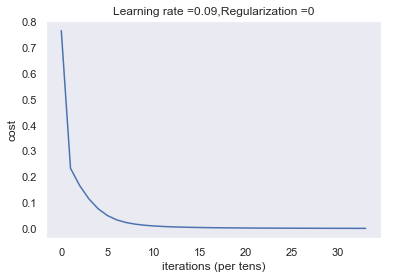

In [118]:
ann_paras = L_layer_model(train_x, train_y, layers_dims,learning_rate = 0.09,lambd = 0,keep_prob = 1.0,
                           num_iterations=2000, print_cost=True,thr_limit =True)

In [106]:
# only including majority opinion 3 seizures
_ = predict(ann_paras,train_x, test_x, train_y, test_y,keep_prob=1.0)

train accuracy: 100.0 %
test accuracy is: 100.0 %
recall is: 100.0 %
precision is: 100.0 %
specificity is: 100.0 %
sensitivity is: 100.0 %
false positive rate is: 0.0 %
false negative rate is: 0.0 %


In [119]:
# including majority opinion 1 and above
_ = predict(ann_paras,train_x, test_x, train_y, test_y,keep_prob=1.0)

train accuracy: 100.0 %
test accuracy is: 100.0 %
recall is: 100.0 %
precision is: 100.0 %
specificity is: 100.0 %
sensitivity is: 100.0 %
false positive rate is: 0.0 %
false negative rate is: 0.0 %


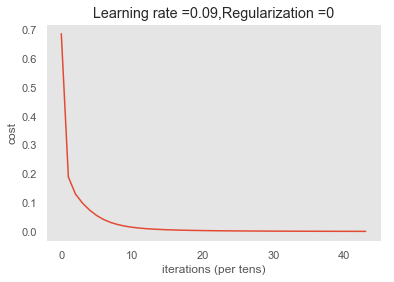

In [401]:
sig_win=512
#layers_dims = [sig_win*n_pairs,1024,512,64,8,1]
layers_dims = [sig_win*n_pairs, 20,10,5,1]
# patient specific training shuru
ann_paras_ps = L_layer_model(train_x, train_y, layers_dims,learning_rate = 0.09,lambd = 0,keep_prob = 1.0,
                           num_iterations=2000, print_cost=True,thr_limit =True)

In [405]:
#lot 3
_ = predict(ann_paras_ps,train_x, test_x, train_y, test_y,keep_prob=1.0)

train accuracy: 100.0 %
test accuracy is: 99.98377676833226 %
recall is: 99.93788819875776 %
precision is: 100.0 %
specificity is: 100.0 %
sensitivity is: 99.93788819875776 %
false positive rate is: 0.0 %
false negative rate is: 0.06211180124223725 %


##   Classical classifers

In [24]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [26]:
def predict_non_nn(X_train,X_test,Y_train,Y_test,classifier):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (false: 0 / true: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    predictions_train = classifier.predict(X_train)
    predictions_test = classifier.predict(X_test)
    test_proba = classifier.predict_proba(X_test)

    
    tp = ((predictions_test== 1) & (Y_test.T ==1)).sum()
    tn = ((predictions_test== 0) & (Y_test.T ==0)).sum()
    fp = ((predictions_test== 1) & (Y_test.T ==0)).sum()
    fn = ((predictions_test== 0) & (Y_test ==1)).sum()
    
    recall = tp / (tp+fn)
    precision = tp /(tp+fp)
    accuracy = (tp + tn) / (tp+tn+fp+fn)
    specificity = tn / (fp + tn)
    sensitivity = tp /(tp + fn)

    
    print('Classifier:',classifier.__class__.__name__)
    print("train accuracy: {} %".format(
        accuracy_score(Y_train,predictions_train) * 100))
    print("test accuracy is: {} %".format(
        accuracy_score(Y_test,predictions_test) * 100))
    print('recall is: {} %'.format(recall*100))
    print('precision is: {} %'.format(precision*100))
    print('specificity is: {} %'.format(specificity*100))
    print('sensitivity is: {} %'.format(sensitivity*100))
    print('false positive rate is: {} %'.format((1.0-specificity)*100))
    print('false negative rate is: {} %'.format((1.0-recall)*100))
    
    return predictions_test,test_proba,[accuracy,specificity,sensitivity,recall]

### training

In [402]:
logreg_clf_raw = linear_model.SGDClassifier(loss='log',penalty='l2',
                                        alpha=0.0001,max_iter=8000, tol=1e-4,learning_rate='constant',
                                       eta0=1e-2,class_weight='balanced')
logreg_clf_raw.fit(train_x.T,train_y.ravel())
_ = predict_non_nn(train_x.T,test_x.T,
                   train_y.ravel(),test_y.ravel(),logreg_clf_raw)

Classifier: SGDClassifier
train accuracy: 100.0 %
test accuracy is: 100.0 %
recall is: 100.0 %
precision is: 100.0 %
specificity is: 100.0 %
sensitivity is: 100.0 %
false positive rate is: 0.0 %
false negative rate is: 0.0 %


In [403]:
ranforrest_clf_raw = RandomForestClassifier(n_estimators=100, max_depth=100,min_samples_split=2,
                                        random_state=0,class_weight='balanced')
ranforrest_clf_raw.fit(train_x.T,train_y.ravel())
_ = predict_non_nn(train_x.T,test_x.T,
                   train_y.ravel(),test_y.ravel(),ranforrest_clf_raw)

Classifier: RandomForestClassifier
train accuracy: 100.0 %
test accuracy is: 100.0 %
recall is: 100.0 %
precision is: 100.0 %
specificity is: 100.0 %
sensitivity is: 100.0 %
false positive rate is: 0.0 %
false negative rate is: 0.0 %


In [404]:
adaboost_clf_raw = AdaBoostClassifier()
adaboost_clf_raw.fit(train_x.T,train_y.ravel())
_ = predict_non_nn(train_x.T,test_x.T,
                   train_y.ravel(),test_y.ravel(),adaboost_clf_raw)

Classifier: AdaBoostClassifier
train accuracy: 100.0 %
test accuracy is: 100.0 %
recall is: 100.0 %
precision is: 100.0 %
specificity is: 100.0 %
sensitivity is: 100.0 %
false positive rate is: 0.0 %
false negative rate is: 0.0 %


In [311]:
lda_clf_raw = LinearDiscriminantAnalysis()
lda_clf_raw.fit(train_x.T,train_y.ravel())
_ = predict_non_nn(train_x.T,test_x.T,
                   train_y.ravel(),test_y.ravel(),lda_clf_raw)

/home/pag/anaconda3/envs/pYthon3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Classifier: LinearDiscriminantAnalysis
train accuracy: 100.0 %
test accuracy is: 99.2801378890804 %
recall is: 99.82898674647285 %
precision is: 97.21065778517902 %
specificity is: 99.10951621477938 %
sensitivity is: 99.82898674647285 %
false positive rate is: 0.8904837852206304 %
false negative rate is: 0.17101325352715246 %


### some visualizations

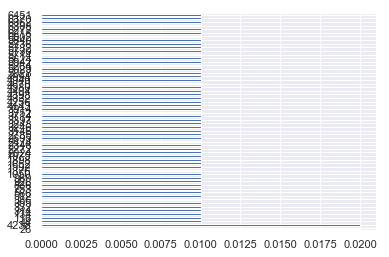

In [164]:
model = ranforrest_clf_raw
feat_importances = pd.Series(model.feature_importances_)
feat_importances.nlargest(60).plot(kind='barh')
plt.show()

In [142]:
def show_prediciton_state(time_slice_ns,time_slice_s,eeg_pairs,clfs_):
    sig_win = 512
    n_pairs = 18

    fig,axes = plt.subplots(n_pairs+1,2,figsize=(15,10), facecolor='w',sharey=False)
    xx_ns = time_slice_ns.reshape(sig_win,n_pairs)
    xx_s = time_slice_s.reshape(sig_win,n_pairs)
    for idx in range(n_pairs):
        axes[idx,0].plot(xx_ns[:,idx],'b')
        axes[idx,1].plot(xx_s[:,idx],'r')
        axes[idx,0].set_ylabel(eeg_pairs[idx],rotation = 45)
        axes[idx,0].set_yticklabels([])
        axes[idx,1].set_yticklabels([])

    
    pred_ns = []
    pred_s = []
    
    for clf in clfs_:
        pred_ns.append(clf.predict(time_slice_ns.reshape(1,-1))[0])
        pred_s.append(clf.predict(time_slice_s.reshape(1,-1))[0])
        
    axes[18,0].plot(np.arange(len(clfs_))*100,pred_ns,linewidth=4)
    axes[18,1].plot(np.arange(len(clfs_))*100,pred_s,color='r',linewidth=4)
    axes[18,0].set_ylim([0,1.5])
    axes[18,1].set_ylim([0,1.5])

    plt.show()
    return None

In [140]:
s_idxs = np.where(test_y==1)[1]
ns_idxs = np.where(test_y==0)[1]

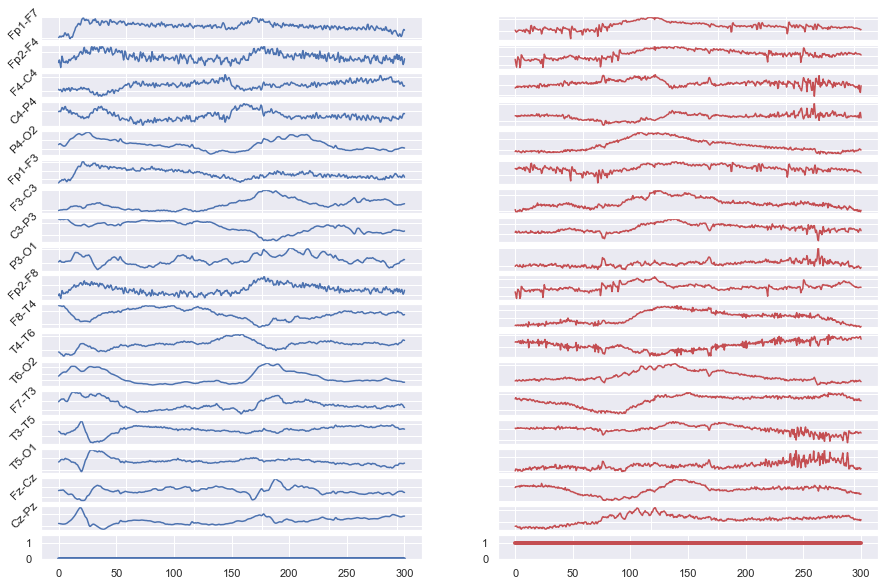

In [151]:
show_prediciton_state(test_x[:,ns_idxs[65]],test_x[:,s_idxs[65]],eeg_pairs,clfs_raw)

## CNN

In [406]:
import numpy as np
import matplotlib.pyplot as plt

from convnet.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from convnet import optim
from IPython.core.pylabtools import figsize
from IPython.display import clear_output
import seaborn as sns
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')

In [407]:
def get_data(X_train,X_val,X_test,y_train,y_val,y_test,sig_win=512,channel_depth=18):
    """
    Load data array already preprocessed to prepare
    it for classifiers. 
    """
    X_train = X_train.reshape(1,sig_win,channel_depth,X_train.shape[1]).transpose(3,2,0,1)
    X_val = X_val.reshape(1,sig_win,channel_depth,X_val.shape[1]).transpose(3,2,0,1)
    X_test = X_test.reshape(1,sig_win,channel_depth,X_test.shape[1]).transpose(3,2,0,1)
    # Package data into a dictionary
    return {
      'X_train': X_train, 'y_train': y_train.ravel().astype(int),
      'X_val': X_val, 'y_val': y_val.ravel().astype(int),
      'X_test': X_test, 'y_test': y_test.ravel().astype(int),
    }

In [170]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    field_height = 1
    assert H  == 1
    assert (W + 2 * padding - field_width) % stride == 0
    out_height = 1
    out_width = (W + 2 * padding - field_width) // stride + 1

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return k, i, j


def im2col_indices(x, field_height, field_width, padding=1, stride=1):
    """ An implementation of im2col based on some fancy indexing """
    # Zero-pad the input
    p = padding
    field_height = 1
    x_padded = np.pad(x, ((0, 0), (0, 0), (0, 0), (p, p)), mode='constant')

    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding,
                                 stride)

    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols
def col2im_indices(cols, x_shape, field_height=1, field_width=3, padding=1,
                   stride=1):
    """ An implementation of col2im based on fancy indexing and np.add.at """
    N, C, H, W = x_shape
    field_height = 1
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding,
                                 stride)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

def conv_forward_im2col(x, w, b, conv_param):
    """
    A fast implementation of the forward pass for a convolutional layer
    based on im2col and col2im.
    """
    N, C, H, W = x.shape
    num_filters, _, filter_height, filter_width = w.shape
    stride, pad = conv_param['stride'], conv_param['pad']

    # Check dimensions
    assert (W + 2 * pad - filter_width) % stride == 0, 'width does not work'
    assert H  == 1, 'height not suitable for time series'

    # Create output
    out_height = 1
    out_width = (W + 2 * pad - filter_width) // stride + 1
    out = np.zeros((N, num_filters, out_height, out_width), dtype=x.dtype)

    x_cols = im2col_indices(x, w.shape[2], w.shape[3], pad, stride)
    # x_cols = im2col_cython(x, w.shape[2], w.shape[3], pad, stride)
    res = w.reshape((w.shape[0], -1)).dot(x_cols) + b.reshape(-1, 1)

    out = res.reshape(w.shape[0], out.shape[2], out.shape[3], x.shape[0])
    out = out.transpose(3, 0, 1, 2)

    cache = (x, w, b, conv_param, x_cols)
    return out, cache

def conv_backward_im2col(dout, cache):
    """
    A fast implementation of the backward pass for a convolutional layer
    based on im2col and col2im.
    """
    x, w, b, conv_param, x_cols = cache
    stride, pad = conv_param['stride'], conv_param['pad']

    db = np.sum(dout, axis=(0, 2, 3))

    num_filters, _, filter_height, filter_width = w.shape
    dout_reshaped = dout.transpose(1, 2, 3, 0).reshape(num_filters, -1)
    dw = dout_reshaped.dot(x_cols.T).reshape(w.shape)

    dx_cols = w.reshape(num_filters, -1).T.dot(dout_reshaped)
    dx = col2im_indices(dx_cols, x.shape, filter_height, filter_width, pad, stride)
    # dx = col2im_cython(dx_cols, x.shape[0], x.shape[1], x.shape[2], x.shape[3],
    #                    filter_height, filter_width, pad, stride)

    return dx, dw, db

def max_pool_forward_im2col(x, pool_param):
    """
    An implementation of the forward pass for max pooling based on im2col.

    This isn't much faster than the naive version, so it should be avoided if
    possible.
    """
    N, C, H, W = x.shape
    pool_height, pool_width = pool_param['pool_height'], pool_param['pool_width']
    stride = pool_param['stride']

    assert H == 1, 'Invalid height'
    assert (W - pool_width) % stride == 0, 'Invalid width'

    out_height = 1
    out_width = (W - pool_width) // stride + 1

    x_split = x.reshape(N * C, 1, H, W)
    x_cols = im2col_indices(x_split, 1, pool_width, padding=0, stride=stride)
    x_cols_argmax = np.argmax(x_cols, axis=0)
    x_cols_max = x_cols[x_cols_argmax, np.arange(x_cols.shape[1])]
    out = x_cols_max.reshape(out_height, out_width, N, C).transpose(2, 3, 0, 1)

    cache = (x, x_cols, x_cols_argmax, pool_param)
    return out, cache


def max_pool_backward_im2col(dout, cache):
    """
    An implementation of the backward pass for max pooling based on im2col.

    This isn't much faster than the naive version, so it should be avoided if
    possible.
    """
    x, x_cols, x_cols_argmax, pool_param = cache
    N, C, H, W = x.shape
    pool_height, pool_width = pool_param['pool_height'], pool_param['pool_width']
    stride = pool_param['stride']

    dout_reshaped = dout.transpose(2, 3, 0, 1).flatten()
    dx_cols = np.zeros_like(x_cols)
    dx_cols[x_cols_argmax, np.arange(dx_cols.shape[1])] = dout_reshaped
    dx = col2im_indices(dx_cols, (N * C, 1, H, W), pool_height, pool_width,
                padding=0, stride=stride)
    dx = dx.reshape(x.shape)

    return dx
def max_pool_forward_fast(x, pool_param):
    """
    A fast implementation of the forward pass for a max pooling layer.

    This chooses between the reshape method and the im2col method. If the pooling
    regions are square and tile the input image, then we can use the reshape
    method which is very fast. Otherwise we fall back on the im2col method, which
    is not much faster than the naive method.
    """
    N, C, H, W = x.shape
    pool_height, pool_width = pool_param['pool_height'], pool_param['pool_width']
    stride = pool_param['stride']

    
    out, im2col_cache = max_pool_forward_im2col(x, pool_param)
    cache = ('im2col', im2col_cache)
    return out, cache


def max_pool_backward_fast(dout, cache):
    """
    A fast implementation of the backward pass for a max pooling layer.

    This switches between the reshape method an the im2col method depending on
    which method was used to generate the cache.
    """
    method, real_cache = cache

    return max_pool_backward_im2col(dout, real_cache)
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    # Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #

    out = x.reshape(x.shape[0], -1).dot(w) + b

    cache = (x, w, b)
    return out, cache


      
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None

    # Implement the affine backward pass.                               #

    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T.dot(dout)
    db = np.sum(dout, axis=0)

    return dx, dw, db

conv_forward_fast = conv_forward_im2col
conv_backward_fast = conv_backward_im2col
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    # Implement the ReLU forward pass.                              

    out = np.maximum(0, x)

    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    # Implement the ReLU backward pass.                              


    dx = (x > 0) * dout

    return dx

def affine_relu_forward(x, w, b):
    """
    Convenience layer that performs an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db


def conv_relu_forward(x, w, b, conv_param):
    """
    A convenience layer that performs a convolution followed by a ReLU.

    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, conv_cache = conv_forward_fast(x, w, b, conv_param)
    out, relu_cache = relu_forward(a)
    cache = (conv_cache, relu_cache)
    return out, cache


def conv_relu_backward(dout, cache):
    """
    Backward pass for the conv-relu convenience layer.
    """
    conv_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = conv_backward_fast(da, conv_cache)
    return dx, dw, db
def conv_relu_pool_forward(x, w, b, conv_param, pool_param):
    """
    Convenience layer that performs a convolution, a ReLU, and a pool.

    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    - pool_param: Parameters for the pooling layer

    Returns a tuple of:
    - out: Output from the pooling layer
    - cache: Object to give to the backward pass
    """
    a, conv_cache = conv_forward_fast(x, w, b, conv_param)
    s, relu_cache = relu_forward(a)
    out, pool_cache = max_pool_forward_fast(s, pool_param)
    cache = (conv_cache, relu_cache, pool_cache)
    return out, cache


def conv_relu_pool_backward(dout, cache):
    """
    Backward pass for the conv-relu-pool convenience layer
    """
    conv_cache, relu_cache, pool_cache = cache
    ds = max_pool_backward_fast(dout, pool_cache)
    da = relu_backward(ds, relu_cache)
    dx, dw, db = conv_backward_fast(da, conv_cache)
    return dx, dw, db

In [171]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx

In [427]:
class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules defined in optim.py.

    The solver accepts both training and validation data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a Solver instance, passing the
    model, dataset, and various options (learning rate, batch size, etc) to the
    constructor. You will then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists of the
    accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = {
      'X_train': # training data
      'y_train': # training labels
      'X_val': # validation data
      'y_val': # validation labels
    }
    model = MyAwesomeModel(hidden_size=100, reg=10)
    solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and
      return a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        self.model = model
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val = data['X_val']
        self.y_val = data['y_val']

        # Unpack keyword arguments
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)
        self.num_train_samples = kwargs.pop('num_train_samples', 1000)
        self.num_val_samples = kwargs.pop('num_val_samples', None)

        self.checkpoint_name = kwargs.pop('checkpoint_name', None)
        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if not hasattr(optim, self.update_rule):
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optim, self.update_rule)

        self._reset()


    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.train_acc_history1 = []
        self.train_acc_history1.append(0)

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d


    def _step(self,t,no_iter):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config
            
        self.visualize_conv1(t,no_iter)


    def _save_checkpoint(self):
        if self.checkpoint_name is None: return
        checkpoint = {
          'model': self.model,
          'update_rule': self.update_rule,
          'lr_decay': self.lr_decay,
          'optim_config': self.optim_config,
          'batch_size': self.batch_size,
          'num_train_samples': self.num_train_samples,
          'num_val_samples': self.num_val_samples,
          'epoch': self.epoch,
          'loss_history': self.loss_history,
          'train_acc_history': self.train_acc_history,
          'val_acc_history': self.val_acc_history,
        }
        filename = '%s_epoch_%d.pkl' % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, 'wb') as f:
            pickle.dump(checkpoint, f)


    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc,y_pred


    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step(t,num_iterations)

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (
                       t + 1, num_iterations, self.loss_history[-1]))

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = (t == 0)
            last_it = (t == num_iterations - 1)
            if first_it or last_it or epoch_end:
                train_acc,_ = self.check_accuracy(self.X_train, self.y_train,
                    num_samples=self.num_train_samples)
                val_acc,_ = self.check_accuracy(self.X_val, self.y_val,
                    num_samples=self.num_val_samples)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()
            
                if self.verbose:
                    print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                           self.epoch, self.num_epochs, train_acc, val_acc))

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()
                
        # At the end of training swap the best params into the model
        self.model.params = self.best_params
        
    def visualize_conv(self,t,num_iter):
        fig = plt.figure(1,figsize=(20,10))
        gridspec.GridSpec(2,4)
        ax = plt.subplot(2,4,1)
        if max(self.loss_history) < 50:
            xx = np.linspace(0,t,len(self.loss_history))
            ax.plot(xx,np.squeeze(self.loss_history))
        if t % 10 == 0:
                train_acc,_ = self.check_accuracy(self.X_train, self.y_train,
                    num_samples=self.num_train_samples)
                self.train_acc_history1.append(train_acc)
        ax.set_xlim(0,num_iter)
        ax.set_ylim(-0.01,min(max(self.loss_history),50))
        ax.text(0.1,1.03,'(Iteration %d / %d)'% (
                       t + 1, num_iter),color= '#e2791d',transform=ax.transAxes)
        ax.text(0.1,0.98,'current cost:'+str(self.loss_history[-1]),color= '#42c2f4',transform=ax.transAxes)
        ax.text(0.6,0.95,'(Epoch %d / %d) ' % (
                           self.epoch, self.num_epochs),color='#000000',transform=ax.transAxes)
        ax.text(0.6,0.90,'train_acc: %f ' % (
                           self.train_acc_history1[-1]),color='#000000',transform=ax.transAxes)

        plt.ylabel('cost')
        plt.xlabel('iterations')
        filter_arr1 = self.model.params['W1'].reshape(6,18,42)
        filter_arr2 = self.model.params['W2'].reshape(4,6,22)
        filter_arr3 = self.model.params['W3'].reshape(3,4,6)
        plt.subplot2grid((2,4),(0,1))
        ax1 = sns.heatmap(filter_arr1[0,:],cmap='gist_earth')
        ax1.set_title('conv1 filter 1')
        plt.subplot2grid((2,4),(0,2))
        ax1 = sns.heatmap(filter_arr1[1,:],cmap='gist_earth')
        ax1.set_title('conv1 filter 2')
        plt.subplot2grid((2,4),(0,3))
        ax2 = sns.heatmap(filter_arr1[2,:],cmap='gist_earth')
        ax2.set_title('conv1 filter 3')
        plt.subplot2grid((2,4),(1,0))
        ax3 = sns.heatmap(filter_arr1[3,:],cmap='gist_earth')
        ax3.set_title('conv1 filter 4')
        plt.subplot2grid((2,4),(1,1))
        ax4 = sns.heatmap(filter_arr2[0,:],cmap='gist_earth')
        ax4.set_title('conv2 filter 1')
        plt.subplot2grid((2,4),(1,2))
        ax5 = sns.heatmap(filter_arr2[1,:],cmap='gist_earth')
        ax5.set_title('conv2 filter 2')
        plt.subplot2grid((2,4),(1,3))
        ax6 = sns.heatmap(filter_arr3[2,:],cmap='gist_earth')
        ax6.set_title('conv3 filter 3')
        
        display.clear_output(wait=True)
        plt.show()
        
    def visualize_conv1(self,t,num_iter):
        fig = plt.figure(1,figsize=(20,10))
        gridspec.GridSpec(2,4)
        plt.subplot(2,4,1)
        if max(self.loss_history) < 50:
            xx = np.linspace(0,t,len(self.loss_history))
            plt.plot(xx,np.squeeze(self.loss_history))
        if t % 10 == 0:
                train_acc,_ = self.check_accuracy(self.X_train, self.y_train,
                    num_samples=self.num_train_samples)
                self.train_acc_history1.append(train_acc)
        plt.xlim(0,num_iter)
        plt.ylim(-0.01,min(max(self.loss_history),50))
        plt.text(10,0.75,'(Iteration %d / %d)'% (
                       t + 1, num_iter),color= '#e2791d')
        plt.text(10,0.70,'current cost:'+str(self.loss_history[-1]),color= '#42c2f4')
        plt.text(2000,0.75,'(Epoch %d / %d) ' % (
                           self.epoch, self.num_epochs),color='#000000')
        plt.text(2000,0.70,'train_acc: %f ' % (
                           self.train_acc_history1[-1]),color='#000000')

        plt.ylabel('cost')
        plt.xlabel('iterations')
        filter_arr1 = self.model.params['W1'].reshape(4,18,15)
        filter_arr2 = self.model.params['W2'].reshape(3,4,10)
        plt.subplot2grid((2,4),(0,1))
        ax1 = sns.heatmap(filter_arr1[0,:],cmap='gist_earth')
        ax1.set_title('conv1 filter 1')
        plt.subplot2grid((2,4),(0,2))
        ax1 = sns.heatmap(filter_arr1[1,:],cmap='gist_earth')
        ax1.set_title('conv1 filter 2')
        plt.subplot2grid((2,4),(0,3))
        ax2 = sns.heatmap(filter_arr1[2,:],cmap='gist_earth')
        ax2.set_title('conv1 filter 3')
        plt.subplot2grid((2,4),(1,0))
        ax3 = sns.heatmap(filter_arr1[3,:],cmap='gist_earth')
        ax3.set_title('conv1 filter 4')
        plt.subplot2grid((2,4),(1,1))
        ax4 = sns.heatmap(filter_arr2[0,:],cmap='gist_earth')
        ax4.set_title('conv2 filter 1')
        plt.subplot2grid((2,4),(1,2))
        ax5 = sns.heatmap(filter_arr2[1,:],cmap='gist_earth')
        ax5.set_title('conv2 filter 2')
        plt.subplot2grid((2,4),(1,3))
        ax6 = sns.heatmap(filter_arr2[2,:],cmap='gist_earth')
        ax6.set_title('conv3 filter 3')
        
        display.clear_output(wait=True)
        plt.show()

In [178]:
class ConvNet(object):
    """
    A n-layer convolutional network with the following architecture:

    conv - relu - 2x2 max pool- .... - affine - relu - affine - softmax

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(self,network,weight_scale=1e-3, reg=0.0,
                 dtype=np.float32):
        """
        Initialize a new network.

        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - num_filters: Number of filters to use in the convolutional layer
        - filter_size: Size of filters to use in the convolutional layer
        - hidden_dim: Number of units to use in the fully-connected hidden layer
        - num_classes: Number of scores to produce from the final affine layer.
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength
        - dtype: numpy datatype to use for computation.
        """
        self.params = {}
        self.conv = {}
        self.reg = reg
        self.dtype = dtype
        self.conv_layers = network['paras']['conv_layers']
        self.no_layers = self.conv_layers  + network['paras']['feed_forward']


        #  Initialize weights and biases for the three-layer convolutional    #
        # network. Weights should be initialized from a Gaussian with standard     #
        # deviation equal to weight_scale; biases should be initialized to zero.   #
        # All weights and biases should be stored in the dictionary self.params.   #

        # Initialize Weights and Biases
        C, H, W = network['conv1']['input_size']
        for layer in range(self.conv_layers):
            num_filters = network['conv'+str(layer+1)]['num_filters']
            C = network['conv'+str(layer+1)]['depth']
            filter_size = network['conv'+str(layer+1)]['filter_size']
            self.params['W'+str(layer+1)] = weight_scale * np.random.randn(num_filters, C, 1, filter_size)
            self.params['b'+str(layer+1)] = np.zeros(num_filters)
            self.conv['conv'+str(layer+1)]={'pool_filter':network['conv'+str(layer+1)]['pool_filter'],
                                              'pool_stride':network['conv'+str(layer+1)]['pool_stride'],
                                             'stride':network['conv'+str(layer+1)]['stride'],
                                             'pad':network['conv'+str(layer+1)]['pad']}
        # Assuming a shape identical to the input image for the conv layer output
        for layer in range(self.conv_layers,self.no_layers):
            input_size = network['ff'+str(layer+1)]['input_size']
            output_size = network['ff'+str(layer+1)]['output_size']
            self.params['W'+str(layer+1)] = weight_scale * np.random.randn(input_size ,output_size)
            self.params['b'+str(layer+1)] = np.zeros(output_size)



        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the three-layer convolutional network.

        Input / output: Same API as TwoLayerNet in fc_net.py.
        """
        scores = None
        out = {}
        cache = {}
        out['0'] = X
        for layer in range(self.conv_layers):
        # pass conv_param to the forward pass for the convolutional layer
            filter_size = self.params['W'+str(layer+1)].shape[3]
            conv_param = {'stride': self.conv['conv'+str(layer+1)]['stride'],
                          'pad': self.conv['conv'+str(layer+1)]['pad']}

        # pass pool_param to the forward pass for the max-pooling layer
            pool_param = {'pool_height': 1, 'pool_width': self.conv['conv'+str(layer+1)]['pool_filter'],
                          'stride': self.conv['conv'+str(layer+1)]['pool_stride']}

        

        # Implement the forward pass for the three-layer convolutional net,  #
        # computing the class scores for X and storing them in the scores          #
        # variable.                                                                #

           
        # Forward Pass: conv - relu - 2x2 max pool - affine - relu - affine - softmax
            out[str(layer+1)], cache[str(layer+1)] = conv_relu_pool_forward(out[str(layer)],
                                                                                          self.params['W'+str(layer+1)],
                                                                                          self.params['b'+str(layer+1)],
                                                                                          conv_param, pool_param)
        for layer in range(self.conv_layers,self.no_layers-1):
            out[str(layer+1)], cache[str(layer+1)] = affine_relu_forward(out[str(layer)], 
                                                                         self.params['W'+str(layer+1)],
                                                                         self.params['b'+str(layer+1)])
        out[str(self.no_layers)], cache[str(self.no_layers)] = affine_forward(out[str(self.no_layers-1)], 
                                                                              self.params['W'+str(self.no_layers)], 
                                                                              self.params['b'+str(self.no_layers)])
        scores = out[str(self.no_layers)]


        if y is None:
            return scores

        loss, grads = 0, {}

        # TODO: Implement the backward pass for the three-layer convolutional net, #
        # storing the loss and gradients in the loss and grads variables. Compute  #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #

        loss, dout = softmax_loss(scores, y)
        loss += self.reg * np.sum([np.sum(self.params['W%d' % i] ** 2) for i in range(1,self.no_layers+1)])
        dout, grads['W'+str(self.no_layers)], grads['b'+str(self.no_layers)] = affine_backward(dout,
                                                                                               cache[str(self.no_layers)])
        grads['W'+str(self.no_layers)] += 2 * self.reg * self.params['W'+str(self.no_layers)]
        for layer in reversed(range(self.conv_layers,self.no_layers-1)):
            dout, grads['W'+str(layer+1)], grads['b'+str(layer+1)] = affine_relu_backward(dout, cache[str(layer+1)])
            grads['W'+str(layer+1)] += 2 * self.reg * self.params['W'+str(layer+1)]   
        for layer in reversed(range(self.conv_layers)):
            dout, grads['W'+str(layer+1)], grads['b'+str(layer+1)] = conv_relu_pool_backward(dout, cache[str(layer+1)])
            grads['W'+str(layer+1)] += 2 * self.reg * self.params['W'+str(layer+1)]
        return loss, grads

In [409]:
data_raw = get_data(train_x,test_x[:,140:580],test_x,train_y,test_y[:,140:580],test_y)
for k, v in data_raw.items():
    print('%s: ' % k, v.shape)

X_train:  (13772, 18, 1, 512)
y_train:  (13772,)
X_val:  (440, 18, 1, 512)
y_val:  (440,)
X_test:  (6164, 18, 1, 512)
y_test:  (6164,)


In [410]:
network_raw = {'paras':{'conv_layers':3,
                   'feed_forward':2},
          'conv1':{'input_size':[18,1,512],
                    'num_filters':6,
                   'depth':18,
                   'filter_size':42,
                   'stride':1,
                   'pad':0,
                   'pool_filter':5,
                   'pool_stride':2},
          'conv2':{'input_size':[6,1,234],
                    'num_filters':4,
                   'depth':6,
                   'filter_size':22,
                   'stride':1,
                   'pad':0,
                   'pool_filter':3,
                   'pool_stride':2},
          'conv3':{'input_size':[4,1,106],
                   'num_filters':3,
                  'depth':4,
                  'filter_size':6,
                  'stride':1,
                  'pad':0,
                  'pool_filter':3,
                  'pool_stride':2},
          'ff4':{'input_size':150,
                 
                'output_size':25},
          'ff5':{'input_size':25,
                 
                'output_size':2}}

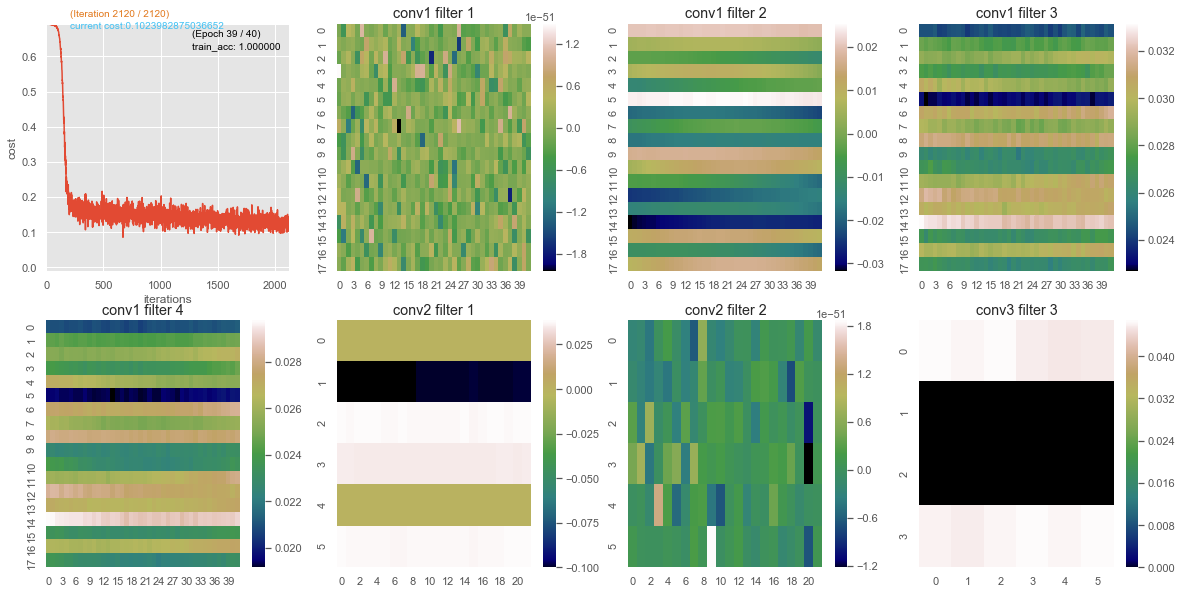

(Epoch 40 / 40) train acc: 0.998000; val_acc: 0.995455


In [413]:
model_raw = ConvNet(network_raw,
                weight_scale=0.001, reg=0.0005)
solver = Solver(model_raw, data_raw,
                num_epochs=40, batch_size=256,                
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=500)

solver.train()

In [181]:
def check_accuracy(model, X, Y_test, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        sftmx_score = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = model.loss(X[start:end])
            sftmx_score.append(scores)
            y_pred.append(np.argmax(scores, axis=1))

        y_pred = np.hstack(y_pred)

        tp = ((y_pred== 1) & (Y_test ==1)).sum()
        tn = ((y_pred== 0) & (Y_test ==0)).sum()
        fp = ((y_pred== 1) & (Y_test ==0)).sum()
        fn = ((y_pred== 0) & (Y_test ==1)).sum()

        recall = tp / (tp+fn)
        precision = tp /(tp+fp)
        accuracy = (tp + tn) / (tp+tn+fp+fn)
        specificity = tn / (fp + tn)
        sensitivity = tp /(tp + fn)

        print("test accuracy is: {} %".format(accuracy*100))
        print('recall is: {} %'.format(recall*100))
        print('precision is: {} %'.format(precision*100))
        print('specificity is: {} %'.format(specificity*100))
        print('sensitivity is: {} %'.format(sensitivity*100))
        print('false positive rate is: {} %'.format((1.0-specificity)*100))
        print('false negative rate is: {} %'.format((1.0-recall)*100))

        return y_pred,sftmx_score,[accuracy,specificity,sensitivity,recall]


In [414]:
_ = check_accuracy(model_raw,data_raw['X_test'],data_raw['y_test'])

test accuracy is: 99.83776768332253 %
recall is: 99.37888198757764 %
precision is: 100.0 %
specificity is: 100.0 %
sensitivity is: 99.37888198757764 %
false positive rate is: 0.0 %
false negative rate is: 0.6211180124223614 %


In [415]:
clfs_raw = [logreg_clf_raw,ranforrest_clf_raw,adaboost_clf_raw,lda_clf_raw]
clf_str = 'test_'+'_'.join(str(e) for e in test_patients)
np.save('raw_data_nn_'+clf_str,ann_paras_ps)
np.save('cnn_raw_data_'+clf_str,model_raw)
for clf in clfs_raw:
    with open(clf.__class__.__name__+'_raw_'+clf_str+'.sav', 'wb') as f:
        pickle.dump(clf,f)

## Synchronisation signature

In [205]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def log_fit(y):
    x = np.arange(1,y.shape[0]+1)
    fit = np.polyfit(np.log(x),np.log(y),1)
    fit_fn = np.poly1d(fit) 
    return fit_fn(np.log(x)),np.log(y)  

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def frequency_signatures(time_slice,left_hemi,right_hemi):
    fs = 256.0
    lowcut = 0.001
    highcut = 50
    seg_len = 256
    n_segment = 512 // seg_len
    N = seg_len
    n_chan = len(left_hemi)
    l_tl = time_slice[:,left_hemi].reshape(n_segment,seg_len,n_chan)
    r_tl = time_slice[:,right_hemi].reshape(n_segment,seg_len,n_chan)
    
    freq_sign_low = []
    freq_sign_mid = []
    freq_sign_high = []
    for chan_no in range(n_chan):
        temp = []
        y_l = np.apply_along_axis(butter_bandpass_filter, 1, l_tl[:,:,chan_no],lowcut,
                                          highcut, fs, order=6)
        y_r = np.apply_along_axis(butter_bandpass_filter, 1, r_tl[:,:,chan_no],lowcut,
                                          highcut, fs, order=6)
        for idx in range(n_segment):

            y_l_fft = np.apply_along_axis(fft,0,y_l[idx,:])
            y_r_fft = np.apply_along_axis(fft,0,y_r[idx,:])


            abs_fft_l = (2.0/N * np.abs(y_l_fft[0:N//2]))
            abs_fft_r = (2.0/N * np.abs(y_r_fft[0:N//2]))


            yfit_l,y_l_fft_log = log_fit(abs_fft_l)
            yfit_r,y_r_fft_log = log_fit(abs_fft_r)

            lfft = yfit_l-y_l_fft_log
            rfft = yfit_r-y_r_fft_log           
            w_H = np.correlate(lfft,rfft ,mode='same')

            if idx == 0:
                temp = w_H
            if idx == 1:
                    freq_sign_low.append(butter_bandpass_filter(np.correlate(w_H,temp,mode='same'),
                                                            1,5, 128, order=6))
                    freq_sign_mid.append(butter_bandpass_filter(np.correlate(w_H,temp,mode='same'),
                                                            5,20, 128, order=6))
                    freq_sign_high.append(butter_bandpass_filter(np.correlate(w_H,temp,mode='same'),
                                                            20,50, 128, order=6))
    return np.asarray(freq_sign_low),np.asarray(freq_sign_mid),np.asarray(freq_sign_high)
w = pywt.Wavelet('db4')

def create_wavedec_coeffs(row_slice,left_hemi,right_hemi,w):
    sig_win = 512
    n_chan = 18
    row_slice = row_slice.reshape(sig_win,n_chan)
    #row_slice = np.apply_along_axis(savgol_filter,0,row_slice,51,11)
    f_low,f_mid,f_high = frequency_signatures(row_slice,left_hemi,right_hemi)
    coeffs_low = dwt(scale(f_low,axis=1,with_mean=True,with_std=True,copy=True),
                  w, axis=0,mode='smooth')
    coeffs_mid = dwt(scale(f_mid,axis=1,with_mean=True,with_std=True,copy=True),
                  w, axis=0,mode='smooth')
    coeffs_high = dwt(scale(f_high,axis=1,with_mean=True,with_std=True,copy=True),
                  w, axis=0,mode='smooth')
    return np.concatenate((np.asarray(coeffs_low[0]),
                           np.asarray(coeffs_mid[0]),
                           np.asarray(coeffs_high[0])),axis=None)

In [196]:
def create_windowed_segs(signal,n_chan = 18):
    sig_win = 512
    sampl_fr = 256
    if signal.shape[0]%sig_win == 0:
        signal_segs = signal.reshape(int(signal.shape[0]/sig_win),
                                                    sig_win,n_chan).transpose(1,2,0)
    else:
        signal_segs = signal[:-sampl_fr,:].reshape(int((signal.shape[0]-sampl_fr)/sig_win),
                                                           sig_win,n_chan).transpose(1,2,0)
    signal_segs = signal_segs.reshape(sig_win*n_chan,-1)
    
    return signal_segs

In [416]:
left_hemi_new = [15,0,6,13,7]
right_hemi_new = [1,9,10,12,2]

In [417]:
ns_freq_feat = np.apply_along_axis(create_wavedec_coeffs, 0,nonseizure_data,left_hemi_new,right_hemi_new,w)
s_freq_feat = np.apply_along_axis(create_wavedec_coeffs, 0, seizure_data,left_hemi_new,right_hemi_new,w)

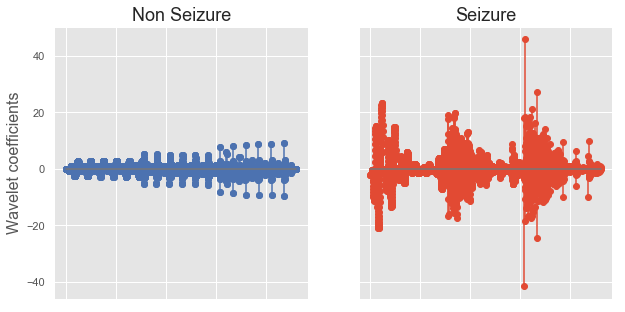

In [418]:
fig,axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True,facecolor='w')
axes[0].stem(ns_freq_feat[:,345],markerfmt='bo',linefmt='bo-')
axes[1].stem(s_freq_feat[:,98])
axes[0].set_title('Non Seizure',fontsize=18)
axes[1].set_title('Seizure',fontsize=18)
axes[0].set_xticklabels([])
axes[0].set_ylabel('Wavelet coefficients',fontsize=16)
plt.show()

In [419]:
train_x_freq_feat,test_x_freq_feat,train_y_ff,test_y_ff = patient_specific_preprocess(s_freq_feat,ns_freq_feat,
                                                                                      patient_ids_s-1,patient_ids_ns-1,
                                                                                      train_patients,test_patients)

The max of nonseizure data is 1.0 and min is -1.0
The max of seizure data is 1.0 and min is -1.0


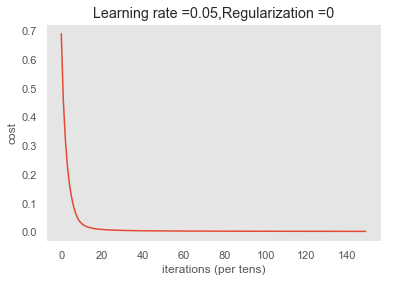

In [421]:
layers_dims = [train_x_freq_feat.shape[0], 1250,750,400,200,50,10,1]

freq_feat_ann_paras = L_layer_model(train_x_freq_feat, train_y_ff, layers_dims,learning_rate = 0.05,lambd = 0,
                                          keep_prob = 1.0,num_iterations=1500,weight_scale=0.001,
                                          print_cost=True,thr_limit = True)

In [422]:
_ = predict(freq_feat_ann_paras,train_x_freq_feat, test_x_freq_feat, train_y_ff, test_y_ff,keep_prob=1.0)

train accuracy: 99.97821667150741 %
test accuracy is: 99.28617780661908 %
recall is: 99.62732919254658 %
precision is: 97.6857490864799 %
specificity is: 99.16556873078612 %
sensitivity is: 99.62732919254658 %
false positive rate is: 0.8344312692138756 %
false negative rate is: 0.3726708074534124 %


In [423]:
def get_data1(X_train,X_val,X_test,y_train,y_val,y_test,sig_win=512,channel_depth=18):
    """
    Load data array already preprocessed to prepare
    it for classifiers. 
    """
    X_train = X_train.reshape(X_train.shape[0],channel_depth,1,sig_win)
    X_val = X_val.reshape(X_val.shape[0],channel_depth,1,sig_win)
    X_test = X_test.reshape(X_test.shape[0],channel_depth,1,sig_win)
    # Package data into a dictionary
    return {
      'X_train': X_train, 'y_train': y_train.ravel().astype(int),
      'X_val': X_val, 'y_val': y_val.ravel().astype(int),
      'X_test': X_test, 'y_test': y_test.ravel().astype(int),
    }

In [424]:
network_ff = {'paras':{'conv_layers':2,
                   'feed_forward':2},
          'conv1':{'input_size':[18,1,128],
                    'num_filters':4,
                   'depth':18,
                   'filter_size':15,
                   'stride':1,
                   'pad':0,
                   'pool_filter':2,
                   'pool_stride':2},
          'conv2':{'input_size':[4,1,57],
                    'num_filters':3,
                   'depth':4,
                   'filter_size':10,
                   'stride':1,
                   'pad':0,
                   'pool_filter':2,
                   'pool_stride':2},
          'ff3':{'input_size':72,
                 
                'output_size':20},
          'ff4':{'input_size':20,
                 
                'output_size':2}}

In [425]:
data_ff = get_data1(train_x_freq_feat.T,test_x_freq_feat[:,300:450].T,test_x_freq_feat.T,
                 train_y_ff,test_y_ff[:,300:450],test_y_ff,sig_win=128,channel_depth=18)
for k, v in data_ff.items():
    print('%s: ' % k, v.shape)

X_train:  (13772, 18, 1, 128)
y_train:  (13772,)
X_val:  (150, 18, 1, 128)
y_val:  (150,)
X_test:  (6164, 18, 1, 128)
y_test:  (6164,)


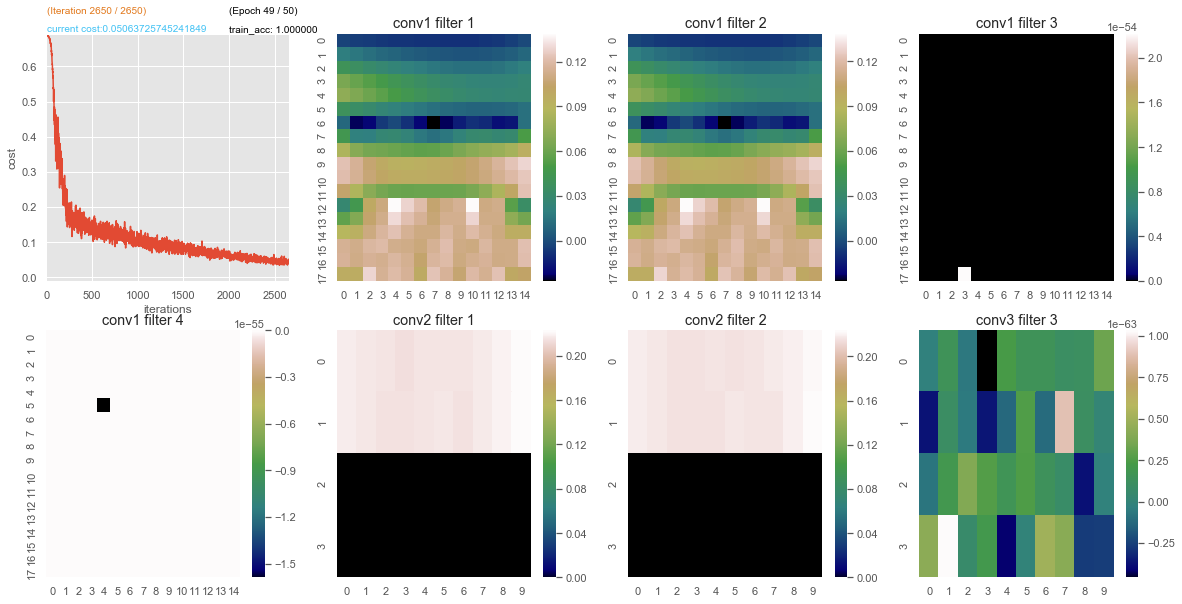

(Epoch 50 / 50) train acc: 1.000000; val_acc: 1.000000


In [428]:
model_ff = ConvNet(network_ff,
                weight_scale=0.001, reg=0.0005)
solver = Solver(model_ff, data_ff,
                num_epochs=50, batch_size=256,                
                update_rule='adam',
                optim_config={
                  'learning_rate': 5e-4,
                },
                verbose=True, print_every=500)

solver.train()

In [429]:
_ = check_accuracy(model_ff,data_ff['X_test'],data_ff['y_test'])

test accuracy is: 99.59441920830629 %
recall is: 98.4472049689441 %
precision is: 100.0 %
specificity is: 100.0 %
sensitivity is: 98.4472049689441 %
false positive rate is: 0.0 %
false negative rate is: 1.552795031055898 %


In [430]:
ranforrest_clf_ff = RandomForestClassifier(n_estimators=100, max_depth=100,min_samples_split=2,
                                        random_state=0,class_weight='balanced')
ranforrest_clf_ff.fit(train_x_freq_feat.T,train_y_ff.ravel())
_ = predict_non_nn(train_x_freq_feat.T,test_x_freq_feat.T,
                   train_y_ff.ravel(),test_y_ff.ravel(),ranforrest_clf_ff)

Classifier: RandomForestClassifier
train accuracy: 100.0 %
test accuracy is: 100.0 %
recall is: 100.0 %
precision is: 100.0 %
specificity is: 100.0 %
sensitivity is: 100.0 %
false positive rate is: 0.0 %
false negative rate is: 0.0 %


In [431]:
adaboost_clf_ff = AdaBoostClassifier()
adaboost_clf_ff.fit(train_x_freq_feat.T,train_y_ff.ravel())
_ = predict_non_nn(train_x_freq_feat.T,test_x_freq_feat.T,
                   train_y_ff.ravel(),test_y_ff.ravel(),adaboost_clf_ff)

Classifier: AdaBoostClassifier
train accuracy: 100.0 %
test accuracy is: 100.0 %
recall is: 100.0 %
precision is: 100.0 %
specificity is: 100.0 %
sensitivity is: 100.0 %
false positive rate is: 0.0 %
false negative rate is: 0.0 %


In [432]:
logreg_clf_ff = linear_model.SGDClassifier(loss='log',penalty='l2',
                                        alpha=0.0001,max_iter=8000, tol=1e-4,learning_rate='constant',
                                       eta0=1e-2,class_weight='balanced')
logreg_clf_ff.fit(train_x_freq_feat.T,train_y_ff.ravel())
_ = predict_non_nn(train_x_freq_feat.T,test_x_freq_feat.T,
                   train_y_ff.ravel(),test_y_ff.ravel(),logreg_clf_ff)

Classifier: SGDClassifier
train accuracy: 100.0 %
test accuracy is: 99.78909798831927 %
recall is: 100.0 %
precision is: 99.19901417128773 %
specificity is: 99.71453667105841 %
sensitivity is: 100.0 %
false positive rate is: 0.2854633289415931 %
false negative rate is: 0.0 %


In [433]:
clfs_ff=[ranforrest_clf_ff,adaboost_clf_ff,logreg_clf_ff]
np.save('ff_nn_'+clf_str,freq_feat_ann_paras)
np.save('cnn_ff_'+clf_str,model_ff)
for clf in clfs_ff:
    with open(clf.__class__.__name__+'_'+clf_str+'.sav', 'wb') as f:
        pickle.dump(clf,f)